In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
cwd_ujoin = cwd.split("\\")[:-2]
basedir = "\\".join(cwd_ujoin)
sys.path.append(basedir)

In [3]:
def rw_sat_dynamics(q, w, rws, T_mtr, T_ext, gs_hat, I_SRW, J_s):
    ws = gs_hat.T@w

    print(f"ws: {ws}")
    qdot = 0.5*np.array([
        [0,    -w[0], -w[1], -w[2]],
        [w[0],     0,  w[2], -w[1]],
        [w[1], -w[2],     0,  w[0]],
        [w[2],  w[1], -w[0],     0]
    ])@q
    print(f"motor component wdot: {np.cross(w, J_s*gs_hat*ws*rws)}")
    wdot = np.linalg.inv(I_SRW)@(-np.cross(w, I_SRW@w) - np.cross(w, J_s*gs_hat*ws*rws) - T_mtr*gs_hat + T_ext)
    rws_dot = T_mtr/J_s - gs_hat.T@wdot
    print(f"rx wheel acc: {rws_dot}")
    return qdot, wdot, rws_dot

In [4]:
def xdot(x, u_mtr, u_ext, gs_hat, I_SRW, J_s):
    qdot, wdot, rws_dot = rw_sat_dynamics(x[:4], x[4:7], x[7], u_mtr, u_ext, gs_hat, I_SRW, J_s)
    return np.hstack((qdot, wdot, rws_dot))

In [5]:
def predict(x, u_mtr, u_ext, gs_hat, I_SRW, J_s, start, end, **solver_opts):
    fx = lambda t, y: xdot(y, u_mtr, u_ext, gs_hat, I_SRW, J_s)
    sol = solve_ivp(fx, [start, end], x, rtol = 1e-5, **solver_opts)
    return sol.y.flatten()

### Define Geometry

In [6]:
# moment of inertia of satellite (including RW assembly)
l, w, h = 10e-2, 10e-2, 10e-2
motor_mass = 200e-3 # 100grams
r_m2com = 5e-2 # 5cm
motor_extra_inertia = 2*motor_mass*r_m2com**2 # assuming offset mass at opposite side
motor_extra_inertia

0.0010000000000000002

In [7]:
base_axial_inertia = ((800e-3)/3)*(l/2)**2
I_sat = np.array([
    [base_axial_inertia+motor_extra_inertia, 0.0, 0.0],
    [0.0, base_axial_inertia+motor_extra_inertia, 0.0],
    [0.0, 0.0, base_axial_inertia]
])
I_sat

array([[0.00166667, 0.        , 0.        ],
       [0.        , 0.00166667, 0.        ],
       [0.        , 0.        , 0.00066667]])

In [8]:
m_disc = 100e-3
r_disc = 0.5e-2
I_disc_s = (m_disc*r_disc**2)/2
I_disc_t = I_disc_s/2
J_s = I_disc_s
J_t = I_disc_t
J_g = I_disc_t

In [9]:
J_s

1.25e-06

In [10]:
gs_hat = np.array([0.0, 0.0, 1.0])
gt_hat = np.array([0.0, 1.0, 0.0])
gg_hat = np.array([1.0, 0.0, 0.0])

In [11]:
I_SRW = I_sat + J_t*gt_hat.reshape((3,1))@gt_hat.reshape((1,3)) + J_g*gg_hat.reshape((3,1))@gg_hat.reshape((1,3))
I_SRW

array([[0.00166729, 0.        , 0.        ],
       [0.        , 0.00166729, 0.        ],
       [0.        , 0.        , 0.00066667]])

### Define Initial Conditions

In [12]:
q0 = np.array([1.0, 0.0, 0.0, 0.0])
w0 = np.array([0.0, 0.0, 0.0])
rws0 = 0.0 # reaction wheel speed
x0 = np.hstack((q0, w0, rws0))
qt = np.array([0.0, 0.0, 0.0, 1.0])
wt = np.array([0.0, 0.0, 0.0])
xt = np.hstack((qt, wt)) #no rx wheel target
u0_ext = np.array([0.0, 0.0, 0.0])
u0_mtr = 0.0

In [13]:
x0

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
t_start = 0
t_end = 180
dt = 0.1
t_vec = np.arange(t_start, t_end + dt, dt)

In [28]:
x = x0
u_ext = u0_ext
u_mtr = u0_mtr
x_history = np.zeros((len(t_vec), len(x)))
err_history = np.zeros((len(t_vec), len(x)-1))
solver_opts = dict(t_eval=[0])

# compute error
Kq = 2e-3
Kq_int = 0e-9
errq_int = 0

Kw = 2e-3*np.array([1.0, 1.0, 1.0])
Kw_int = 0*np.array([1.0, 1.0, 1.0])
errw_int = 0

for idx, t in enumerate(t_vec):
    err = xt - x[:-1]
    err_q = (1 - np.dot(xt[:4], x[:4]))
    err_w = err[4:]
    errq_int += err_q
    errw_int += err_w
    u_mtr = -(Kq*err_q + Kq_int*errq_int*dt + Kw@err_w + Kw_int@errw_int*dt)
    print(f"Speed Effort: {Kw@err[4:]}")
    print(f"Motor Torque: {u_mtr}")
    x_history[idx, :] = x
    err_history[idx, :] = err
    start = t
    end = t + dt
    solver_opts['t_eval'] = [end]
    xnew = predict(x, u_mtr, u_ext, gs_hat, I_SRW, J_s, start, end, **solver_opts)
    x = xnew

Speed Effort: 0.0
Motor Torque: -0.002
ws: 0.0
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 1.7013524336733457e-06
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 3.4027048673466914e-05
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 5.104057301020037e-05
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.0001361081946938676
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.0001512313274376307
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.00017013524336733458
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.00017013524336733455
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.0005104057301020037
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.0006805409734693382
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.0015312171903060104
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws: 0.0016824485177436416
motor component wdot: [0. 0. 0.]
rx wheel acc: -1603.0
ws:

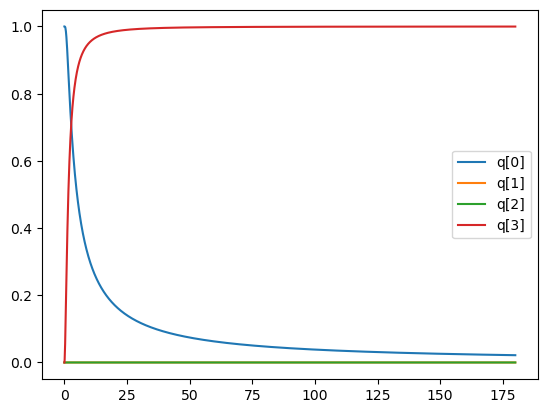

In [29]:
plt.plot(t_vec, x_history[:, :4])
plt.legend(["q[0]", "q[1]", "q[2]", "q[3]"])

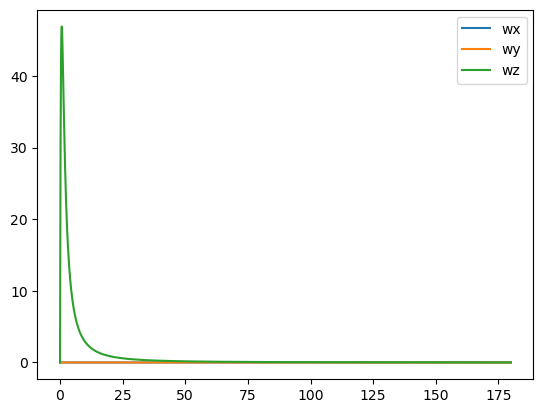

In [30]:
plt.plot(t_vec, np.rad2deg(x_history[:, 4:7]))
plt.legend(["wx", "wy", "wz"])

(-0.5, 2.0)

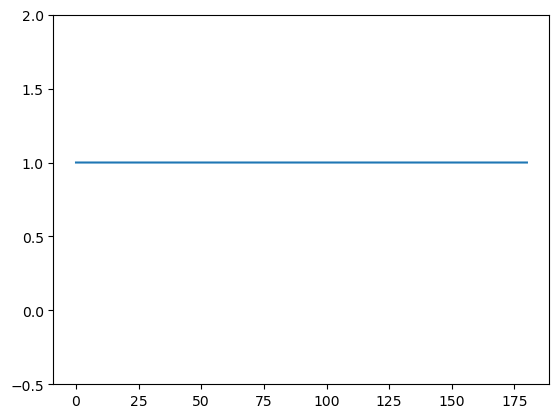

In [31]:
plt.plot(t_vec, np.linalg.norm(x_history[:, :4], axis=1))
plt.ylim(-0.5, 2)

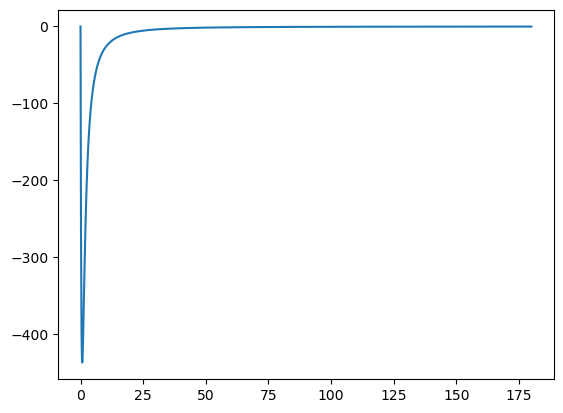

In [32]:
plt.plot(t_vec, x_history[:, 7])

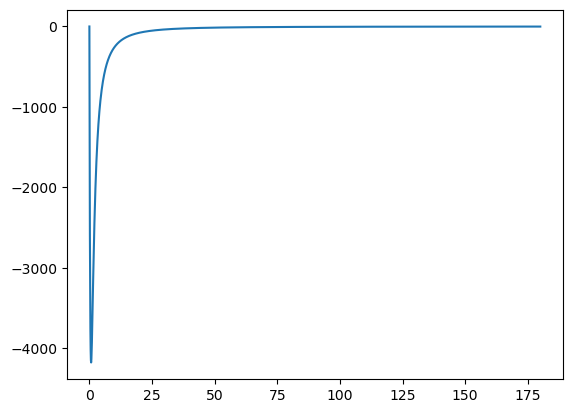

In [33]:
plt.plot(t_vec, x_history[:, 7]*(60/(2*np.pi)))